In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 of58uq12


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-of58uq12:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                       | 0/330 [00:00<?, ?it/s]

  0%|▎                                                                                              | 1/330 [00:00<03:46,  1.46it/s]

  1%|▌                                                                                              | 2/330 [00:00<02:15,  2.43it/s]

  1%|▊                                                                                              | 3/330 [00:01<01:45,  3.09it/s]

  1%|█▏                                                                                             | 4/330 [00:01<01:31,  3.55it/s]

  2%|█▍                                                                                             | 5/330 [00:01<01:24,  3.86it/s]

  2%|█▋                                                                                             | 6/330 [00:01<01:19,  4.08it/s]

  2%|██                                                                                             | 7/330 [00:01<01:16,  4.23it/s]

  2%|██▎                                                                                            | 8/330 [00:02<01:14,  4.34it/s]

  3%|██▌                                                                                            | 9/330 [00:02<01:12,  4.42it/s]

  3%|██▊                                                                                           | 10/330 [00:02<01:11,  4.47it/s]

  3%|███▏                                                                                          | 11/330 [00:02<01:10,  4.50it/s]

  4%|███▍                                                                                          | 12/330 [00:03<01:10,  4.53it/s]

  4%|███▋                                                                                          | 13/330 [00:03<01:09,  4.55it/s]

  4%|███▉                                                                                          | 14/330 [00:03<01:09,  4.56it/s]

  5%|████▎                                                                                         | 15/330 [00:03<01:08,  4.57it/s]

  5%|████▌                                                                                         | 16/330 [00:03<01:08,  4.57it/s]

  5%|████▊                                                                                         | 17/330 [00:04<01:08,  4.58it/s]

  5%|█████▏                                                                                        | 18/330 [00:04<01:08,  4.58it/s]

  6%|█████▍                                                                                        | 19/330 [00:04<01:07,  4.58it/s]

  6%|█████▋                                                                                        | 20/330 [00:04<01:07,  4.58it/s]

  6%|█████▉                                                                                        | 21/330 [00:05<01:07,  4.59it/s]

  7%|██████▎                                                                                       | 22/330 [00:05<01:07,  4.59it/s]

  7%|██████▌                                                                                       | 23/330 [00:05<01:06,  4.59it/s]

  7%|██████▊                                                                                       | 24/330 [00:05<01:06,  4.59it/s]

  8%|███████                                                                                       | 25/330 [00:05<01:06,  4.59it/s]

  8%|███████▍                                                                                      | 26/330 [00:06<01:06,  4.59it/s]

  8%|███████▋                                                                                      | 27/330 [00:06<01:06,  4.59it/s]

  8%|███████▉                                                                                      | 28/330 [00:06<01:05,  4.59it/s]

  9%|████████▎                                                                                     | 29/330 [00:06<01:05,  4.59it/s]

  9%|████████▌                                                                                     | 30/330 [00:07<01:05,  4.59it/s]

  9%|████████▊                                                                                     | 31/330 [00:07<01:05,  4.59it/s]

 10%|█████████                                                                                     | 32/330 [00:07<01:04,  4.59it/s]

 10%|█████████▍                                                                                    | 33/330 [00:07<01:04,  4.59it/s]

 10%|█████████▋                                                                                    | 34/330 [00:07<01:04,  4.59it/s]

 11%|█████████▉                                                                                    | 35/330 [00:08<01:04,  4.59it/s]

 11%|██████████▎                                                                                   | 36/330 [00:08<01:04,  4.59it/s]

 11%|██████████▌                                                                                   | 37/330 [00:08<01:03,  4.59it/s]

 12%|██████████▊                                                                                   | 38/330 [00:08<01:03,  4.59it/s]

 12%|███████████                                                                                   | 39/330 [00:08<01:03,  4.59it/s]

 12%|███████████▍                                                                                  | 40/330 [00:09<01:03,  4.59it/s]

 12%|███████████▋                                                                                  | 41/330 [00:09<01:02,  4.59it/s]

 13%|███████████▉                                                                                  | 42/330 [00:09<01:02,  4.59it/s]

 13%|████████████▏                                                                                 | 43/330 [00:09<01:02,  4.59it/s]

 13%|████████████▌                                                                                 | 44/330 [00:10<01:02,  4.59it/s]

 14%|████████████▊                                                                                 | 45/330 [00:10<01:02,  4.59it/s]

 14%|█████████████                                                                                 | 46/330 [00:10<01:01,  4.59it/s]

 14%|█████████████▍                                                                                | 47/330 [00:10<01:01,  4.59it/s]

 15%|█████████████▋                                                                                | 48/330 [00:10<01:01,  4.59it/s]

 15%|█████████████▉                                                                                | 49/330 [00:11<01:01,  4.59it/s]

 15%|██████████████▏                                                                               | 50/330 [00:11<01:01,  4.59it/s]

 15%|██████████████▌                                                                               | 51/330 [00:11<01:00,  4.59it/s]

 16%|██████████████▊                                                                               | 52/330 [00:11<01:00,  4.59it/s]

 16%|███████████████                                                                               | 53/330 [00:12<01:00,  4.59it/s]

 16%|███████████████▍                                                                              | 54/330 [00:12<01:00,  4.59it/s]

 17%|███████████████▋                                                                              | 55/330 [00:12<00:59,  4.59it/s]

 17%|███████████████▉                                                                              | 56/330 [00:12<00:59,  4.59it/s]

 17%|████████████████▏                                                                             | 57/330 [00:12<00:59,  4.59it/s]

 18%|████████████████▌                                                                             | 58/330 [00:13<00:59,  4.59it/s]

 18%|████████████████▊                                                                             | 59/330 [00:13<00:59,  4.59it/s]

 18%|█████████████████                                                                             | 60/330 [00:13<00:58,  4.59it/s]

 18%|█████████████████▍                                                                            | 61/330 [00:13<00:58,  4.59it/s]

 19%|█████████████████▋                                                                            | 62/330 [00:13<00:58,  4.59it/s]

 19%|█████████████████▉                                                                            | 63/330 [00:14<00:58,  4.59it/s]

 19%|██████████████████▏                                                                           | 64/330 [00:14<00:58,  4.58it/s]

 20%|██████████████████▌                                                                           | 65/330 [00:14<00:57,  4.58it/s]

 20%|██████████████████▊                                                                           | 66/330 [00:14<00:57,  4.59it/s]

 20%|███████████████████                                                                           | 67/330 [00:15<00:57,  4.59it/s]

 21%|███████████████████▎                                                                          | 68/330 [00:15<00:57,  4.59it/s]

 21%|███████████████████▋                                                                          | 69/330 [00:15<00:56,  4.59it/s]

 21%|███████████████████▉                                                                          | 70/330 [00:15<00:56,  4.59it/s]

 22%|████████████████████▏                                                                         | 71/330 [00:15<00:56,  4.58it/s]

 22%|████████████████████▌                                                                         | 72/330 [00:16<00:56,  4.58it/s]

 22%|████████████████████▊                                                                         | 73/330 [00:16<00:56,  4.58it/s]

 22%|█████████████████████                                                                         | 74/330 [00:16<00:55,  4.59it/s]

 23%|█████████████████████▎                                                                        | 75/330 [00:16<00:55,  4.59it/s]

 23%|█████████████████████▋                                                                        | 76/330 [00:17<00:55,  4.59it/s]

 23%|█████████████████████▉                                                                        | 77/330 [00:17<00:55,  4.59it/s]

 24%|██████████████████████▏                                                                       | 78/330 [00:17<00:54,  4.59it/s]

 24%|██████████████████████▌                                                                       | 79/330 [00:17<00:54,  4.59it/s]

 24%|██████████████████████▊                                                                       | 80/330 [00:17<00:54,  4.59it/s]

 25%|███████████████████████                                                                       | 81/330 [00:18<00:54,  4.59it/s]

 25%|███████████████████████▎                                                                      | 82/330 [00:18<00:54,  4.59it/s]

 25%|███████████████████████▋                                                                      | 83/330 [00:18<00:53,  4.59it/s]

 25%|███████████████████████▉                                                                      | 84/330 [00:18<00:53,  4.59it/s]

 26%|████████████████████████▏                                                                     | 85/330 [00:19<00:53,  4.59it/s]

 26%|████████████████████████▍                                                                     | 86/330 [00:19<00:53,  4.59it/s]

 26%|████████████████████████▊                                                                     | 87/330 [00:19<00:52,  4.59it/s]

 27%|█████████████████████████                                                                     | 88/330 [00:19<00:52,  4.59it/s]

 27%|█████████████████████████▎                                                                    | 89/330 [00:19<00:52,  4.59it/s]

 27%|█████████████████████████▋                                                                    | 90/330 [00:20<00:52,  4.59it/s]

 28%|█████████████████████████▉                                                                    | 91/330 [00:20<00:52,  4.59it/s]

 28%|██████████████████████████▏                                                                   | 92/330 [00:20<00:51,  4.59it/s]

 28%|██████████████████████████▍                                                                   | 93/330 [00:20<00:51,  4.59it/s]

 28%|██████████████████████████▊                                                                   | 94/330 [00:20<00:51,  4.59it/s]

 29%|███████████████████████████                                                                   | 95/330 [00:21<00:51,  4.59it/s]

 29%|███████████████████████████▎                                                                  | 96/330 [00:21<00:51,  4.59it/s]

 29%|███████████████████████████▋                                                                  | 97/330 [00:21<00:50,  4.59it/s]

 30%|███████████████████████████▉                                                                  | 98/330 [00:21<00:50,  4.59it/s]

 30%|████████████████████████████▏                                                                 | 99/330 [00:22<00:50,  4.59it/s]

 30%|████████████████████████████▏                                                                | 100/330 [00:22<00:50,  4.59it/s]

 31%|████████████████████████████▍                                                                | 101/330 [00:22<00:49,  4.59it/s]

 31%|████████████████████████████▋                                                                | 102/330 [00:22<00:49,  4.59it/s]

 31%|█████████████████████████████                                                                | 103/330 [00:22<00:49,  4.59it/s]

 32%|█████████████████████████████▎                                                               | 104/330 [00:23<00:49,  4.59it/s]

 32%|█████████████████████████████▌                                                               | 105/330 [00:23<00:49,  4.59it/s]

 32%|█████████████████████████████▊                                                               | 106/330 [00:23<00:48,  4.59it/s]

 32%|██████████████████████████████▏                                                              | 107/330 [00:23<00:48,  4.59it/s]

 33%|██████████████████████████████▍                                                              | 108/330 [00:24<00:48,  4.59it/s]

 33%|██████████████████████████████▋                                                              | 109/330 [00:24<00:48,  4.59it/s]

 33%|███████████████████████████████                                                              | 110/330 [00:24<00:47,  4.59it/s]

 34%|███████████████████████████████▎                                                             | 111/330 [00:24<00:47,  4.59it/s]

 34%|███████████████████████████████▌                                                             | 112/330 [00:24<00:47,  4.59it/s]

 34%|███████████████████████████████▊                                                             | 113/330 [00:25<00:47,  4.59it/s]

 35%|████████████████████████████████▏                                                            | 114/330 [00:25<00:47,  4.59it/s]

 35%|████████████████████████████████▍                                                            | 115/330 [00:25<00:46,  4.59it/s]

 35%|████████████████████████████████▋                                                            | 116/330 [00:25<00:46,  4.59it/s]

 35%|████████████████████████████████▉                                                            | 117/330 [00:25<00:46,  4.59it/s]

 36%|█████████████████████████████████▎                                                           | 118/330 [00:26<00:46,  4.59it/s]

 36%|█████████████████████████████████▌                                                           | 119/330 [00:26<00:45,  4.59it/s]

 36%|█████████████████████████████████▊                                                           | 120/330 [00:26<00:45,  4.59it/s]

 37%|██████████████████████████████████                                                           | 121/330 [00:26<00:45,  4.58it/s]

 37%|██████████████████████████████████▍                                                          | 122/330 [00:27<00:45,  4.59it/s]

 37%|██████████████████████████████████▋                                                          | 123/330 [00:27<00:45,  4.59it/s]

 38%|██████████████████████████████████▉                                                          | 124/330 [00:27<00:44,  4.59it/s]

 38%|███████████████████████████████████▏                                                         | 125/330 [00:27<00:44,  4.59it/s]

 38%|███████████████████████████████████▌                                                         | 126/330 [00:27<00:44,  4.59it/s]

 38%|███████████████████████████████████▊                                                         | 127/330 [00:28<00:44,  4.59it/s]

 39%|████████████████████████████████████                                                         | 128/330 [00:28<00:44,  4.59it/s]

 39%|████████████████████████████████████▎                                                        | 129/330 [00:28<00:43,  4.59it/s]

 39%|████████████████████████████████████▋                                                        | 130/330 [00:28<00:43,  4.59it/s]

 40%|████████████████████████████████████▉                                                        | 131/330 [00:29<00:43,  4.59it/s]

 40%|█████████████████████████████████████▏                                                       | 132/330 [00:29<00:43,  4.59it/s]

 40%|█████████████████████████████████████▍                                                       | 133/330 [00:29<00:42,  4.59it/s]

 41%|█████████████████████████████████████▊                                                       | 134/330 [00:29<00:42,  4.59it/s]

 41%|██████████████████████████████████████                                                       | 135/330 [00:29<00:42,  4.59it/s]

 41%|██████████████████████████████████████▎                                                      | 136/330 [00:30<00:42,  4.59it/s]

 42%|██████████████████████████████████████▌                                                      | 137/330 [00:30<00:42,  4.59it/s]

 42%|██████████████████████████████████████▉                                                      | 138/330 [00:30<00:41,  4.59it/s]

 42%|███████████████████████████████████████▏                                                     | 139/330 [00:30<00:41,  4.59it/s]

 42%|███████████████████████████████████████▍                                                     | 140/330 [00:30<00:41,  4.59it/s]

 43%|███████████████████████████████████████▋                                                     | 141/330 [00:31<00:41,  4.59it/s]

 43%|████████████████████████████████████████                                                     | 142/330 [00:31<00:40,  4.59it/s]

 43%|████████████████████████████████████████▎                                                    | 143/330 [00:31<00:40,  4.59it/s]

 44%|████████████████████████████████████████▌                                                    | 144/330 [00:31<00:40,  4.59it/s]

 44%|████████████████████████████████████████▊                                                    | 145/330 [00:32<00:40,  4.59it/s]

 44%|█████████████████████████████████████████▏                                                   | 146/330 [00:32<00:40,  4.59it/s]

 45%|█████████████████████████████████████████▍                                                   | 147/330 [00:32<00:39,  4.59it/s]

 45%|█████████████████████████████████████████▋                                                   | 148/330 [00:32<00:39,  4.59it/s]

 45%|█████████████████████████████████████████▉                                                   | 149/330 [00:32<00:39,  4.59it/s]

 45%|██████████████████████████████████████████▎                                                  | 150/330 [00:33<00:39,  4.59it/s]

 46%|██████████████████████████████████████████▌                                                  | 151/330 [00:33<00:39,  4.59it/s]

 46%|██████████████████████████████████████████▊                                                  | 152/330 [00:33<00:38,  4.59it/s]

 46%|███████████████████████████████████████████                                                  | 153/330 [00:33<00:38,  4.59it/s]

 47%|███████████████████████████████████████████▍                                                 | 154/330 [00:34<00:38,  4.59it/s]

 47%|███████████████████████████████████████████▋                                                 | 155/330 [00:34<00:38,  4.59it/s]

 47%|███████████████████████████████████████████▉                                                 | 156/330 [00:34<00:37,  4.59it/s]

 48%|████████████████████████████████████████████▏                                                | 157/330 [00:34<00:37,  4.59it/s]

 48%|████████████████████████████████████████████▌                                                | 158/330 [00:34<00:37,  4.59it/s]

 48%|████████████████████████████████████████████▊                                                | 159/330 [00:35<00:37,  4.59it/s]

 48%|█████████████████████████████████████████████                                                | 160/330 [00:35<00:37,  4.59it/s]

 49%|█████████████████████████████████████████████▎                                               | 161/330 [00:35<00:36,  4.59it/s]

 49%|█████████████████████████████████████████████▋                                               | 162/330 [00:35<00:36,  4.59it/s]

 49%|█████████████████████████████████████████████▉                                               | 163/330 [00:36<00:36,  4.59it/s]

 50%|██████████████████████████████████████████████▏                                              | 164/330 [00:36<00:36,  4.59it/s]

 50%|██████████████████████████████████████████████▌                                              | 165/330 [00:36<00:35,  4.59it/s]

 50%|██████████████████████████████████████████████▊                                              | 166/330 [00:36<00:35,  4.59it/s]

 51%|███████████████████████████████████████████████                                              | 167/330 [00:36<00:35,  4.59it/s]

 51%|███████████████████████████████████████████████▎                                             | 168/330 [00:37<00:35,  4.59it/s]

 51%|███████████████████████████████████████████████▋                                             | 169/330 [00:37<00:35,  4.59it/s]

 52%|███████████████████████████████████████████████▉                                             | 170/330 [00:37<00:34,  4.59it/s]

 52%|████████████████████████████████████████████████▏                                            | 171/330 [00:37<00:34,  4.59it/s]

 52%|████████████████████████████████████████████████▍                                            | 172/330 [00:37<00:34,  4.59it/s]

 52%|████████████████████████████████████████████████▊                                            | 173/330 [00:38<00:34,  4.59it/s]

 53%|█████████████████████████████████████████████████                                            | 174/330 [00:38<00:34,  4.59it/s]

 53%|█████████████████████████████████████████████████▎                                           | 175/330 [00:38<00:33,  4.59it/s]

 53%|█████████████████████████████████████████████████▌                                           | 176/330 [00:38<00:33,  4.59it/s]

 54%|█████████████████████████████████████████████████▉                                           | 177/330 [00:39<00:33,  4.59it/s]

 54%|██████████████████████████████████████████████████▏                                          | 178/330 [00:39<00:33,  4.59it/s]

 54%|██████████████████████████████████████████████████▍                                          | 179/330 [00:39<00:32,  4.59it/s]

 55%|██████████████████████████████████████████████████▋                                          | 180/330 [00:39<00:32,  4.59it/s]

 55%|███████████████████████████████████████████████████                                          | 181/330 [00:39<00:32,  4.59it/s]

 55%|███████████████████████████████████████████████████▎                                         | 182/330 [00:40<00:32,  4.59it/s]

 55%|███████████████████████████████████████████████████▌                                         | 183/330 [00:40<00:32,  4.59it/s]

 56%|███████████████████████████████████████████████████▊                                         | 184/330 [00:40<00:31,  4.59it/s]

 56%|████████████████████████████████████████████████████▏                                        | 185/330 [00:40<00:31,  4.59it/s]

 56%|████████████████████████████████████████████████████▍                                        | 186/330 [00:41<00:31,  4.59it/s]

 57%|████████████████████████████████████████████████████▋                                        | 187/330 [00:41<00:31,  4.59it/s]

 57%|████████████████████████████████████████████████████▉                                        | 188/330 [00:41<00:30,  4.59it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 189/330 [00:41<00:30,  4.59it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 190/330 [00:41<00:30,  4.59it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 191/330 [00:42<00:30,  4.59it/s]

 58%|██████████████████████████████████████████████████████                                       | 192/330 [00:42<00:30,  4.59it/s]

 58%|██████████████████████████████████████████████████████▍                                      | 193/330 [00:42<00:29,  4.59it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 194/330 [00:42<00:29,  4.59it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 195/330 [00:42<00:29,  4.59it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 196/330 [00:43<00:29,  4.58it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 197/330 [00:43<00:29,  4.59it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 198/330 [00:43<00:28,  4.59it/s]

 60%|████████████████████████████████████████████████████████                                     | 199/330 [00:43<00:28,  4.59it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 200/330 [00:44<00:28,  4.59it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 201/330 [00:44<00:28,  4.59it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 202/330 [00:44<00:27,  4.59it/s]

 62%|█████████████████████████████████████████████████████████▏                                   | 203/330 [00:44<00:27,  4.57it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 204/330 [00:44<00:27,  4.56it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 205/330 [00:45<00:27,  4.55it/s]

 62%|██████████████████████████████████████████████████████████                                   | 206/330 [00:45<00:27,  4.55it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 207/330 [00:45<00:27,  4.55it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 208/330 [00:45<00:26,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 209/330 [00:46<00:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 210/330 [00:46<00:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 211/330 [00:46<00:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 212/330 [00:46<00:25,  4.54it/s]

 65%|████████████████████████████████████████████████████████████                                 | 213/330 [00:46<00:25,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 214/330 [00:47<00:25,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 215/330 [00:47<00:25,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 216/330 [00:47<00:25,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 217/330 [00:47<00:24,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 218/330 [00:48<00:24,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 219/330 [00:48<00:24,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████                               | 220/330 [00:48<00:24,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 221/330 [00:48<00:24,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 222/330 [00:48<00:23,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 223/330 [00:49<00:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 224/330 [00:49<00:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 225/330 [00:49<00:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 226/330 [00:49<00:22,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 227/330 [00:50<00:22,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 228/330 [00:50<00:22,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 229/330 [00:50<00:22,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 230/330 [00:50<00:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 231/330 [00:50<00:21,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 232/330 [00:51<00:21,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 233/330 [00:51<00:21,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 234/330 [00:51<00:21,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 235/330 [00:51<00:20,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 236/330 [00:51<00:20,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 237/330 [00:52<00:20,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 238/330 [00:52<00:20,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 239/330 [00:52<00:20,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 240/330 [00:52<00:19,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 241/330 [00:53<00:19,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 242/330 [00:53<00:19,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 243/330 [00:53<00:19,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 244/330 [00:53<00:18,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 245/330 [00:53<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 246/330 [00:54<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 247/330 [00:54<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 248/330 [00:54<00:18,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 249/330 [00:54<00:17,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 250/330 [00:55<00:17,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 251/330 [00:55<00:17,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 252/330 [00:55<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 253/330 [00:55<00:16,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 254/330 [00:55<00:16,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 255/330 [00:56<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 256/330 [00:56<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 257/330 [00:56<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 258/330 [00:56<00:15,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 259/330 [00:57<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 260/330 [00:57<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 261/330 [00:57<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 262/330 [00:57<00:14,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 263/330 [00:57<00:14,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 264/330 [00:58<00:14,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 265/330 [00:58<00:14,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 266/330 [00:58<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 267/330 [00:58<00:13,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 268/330 [00:59<00:13,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 269/330 [00:59<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 270/330 [00:59<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 271/330 [00:59<00:12,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 272/330 [00:59<00:12,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 273/330 [01:00<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 274/330 [01:00<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 275/330 [01:00<00:12,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 276/330 [01:00<00:11,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 277/330 [01:01<00:11,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 278/330 [01:01<00:11,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 279/330 [01:01<00:11,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 280/330 [01:01<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 281/330 [01:01<00:10,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 282/330 [01:02<00:10,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 283/330 [01:02<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 284/330 [01:02<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 285/330 [01:02<00:09,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 286/330 [01:03<00:09,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 287/330 [01:03<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 288/330 [01:03<00:09,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 289/330 [01:03<00:09,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 290/330 [01:03<00:08,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 291/330 [01:04<00:08,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 292/330 [01:04<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 293/330 [01:04<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 294/330 [01:04<00:07,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 295/330 [01:04<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 296/330 [01:05<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 297/330 [01:05<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 298/330 [01:05<00:07,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 299/330 [01:05<00:06,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 300/330 [01:06<00:06,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 301/330 [01:06<00:06,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████        | 302/330 [01:06<00:06,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 303/330 [01:06<00:05,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 304/330 [01:06<00:05,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 305/330 [01:07<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 306/330 [01:07<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 307/330 [01:07<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 308/330 [01:07<00:04,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 309/330 [01:08<00:04,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 310/330 [01:08<00:04,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 311/330 [01:08<00:04,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 312/330 [01:08<00:03,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 313/330 [01:08<00:03,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 314/330 [01:09<00:03,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 315/330 [01:09<00:03,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 316/330 [01:09<00:03,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 317/330 [01:09<00:02,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 318/330 [01:10<00:02,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 319/330 [01:10<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 320/330 [01:10<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 321/330 [01:10<00:01,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 322/330 [01:10<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 323/330 [01:11<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 324/330 [01:11<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 325/330 [01:11<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 326/330 [01:11<00:00,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 327/330 [01:12<00:00,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 328/330 [01:12<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 329/330 [01:12<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:12<00:00,  5.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:12<00:00,  4.55it/s]

train - OK


  0%|                                                                                                        | 0/42 [00:00<?, ?it/s]

  2%|██▎                                                                                             | 1/42 [00:00<00:13,  3.08it/s]

  5%|████▌                                                                                           | 2/42 [00:00<00:10,  3.79it/s]

  7%|██████▊                                                                                         | 3/42 [00:00<00:09,  4.10it/s]

 10%|█████████▏                                                                                      | 4/42 [00:00<00:08,  4.26it/s]

 12%|███████████▍                                                                                    | 5/42 [00:01<00:08,  4.36it/s]

 14%|█████████████▋                                                                                  | 6/42 [00:01<00:08,  4.42it/s]

 17%|████████████████                                                                                | 7/42 [00:01<00:07,  4.45it/s]

 19%|██████████████████▎                                                                             | 8/42 [00:01<00:07,  4.48it/s]

 21%|████████████████████▌                                                                           | 9/42 [00:02<00:07,  4.50it/s]

 24%|██████████████████████▌                                                                        | 10/42 [00:02<00:07,  4.51it/s]

 26%|████████████████████████▉                                                                      | 11/42 [00:02<00:06,  4.52it/s]

 29%|███████████████████████████▏                                                                   | 12/42 [00:02<00:06,  4.52it/s]

 31%|█████████████████████████████▍                                                                 | 13/42 [00:02<00:06,  4.53it/s]

 33%|███████████████████████████████▋                                                               | 14/42 [00:03<00:06,  4.53it/s]

 36%|█████████████████████████████████▉                                                             | 15/42 [00:03<00:05,  4.53it/s]

 38%|████████████████████████████████████▏                                                          | 16/42 [00:03<00:05,  4.53it/s]

 40%|██████████████████████████████████████▍                                                        | 17/42 [00:03<00:05,  4.54it/s]

 43%|████████████████████████████████████████▋                                                      | 18/42 [00:04<00:05,  4.54it/s]

 45%|██████████████████████████████████████████▉                                                    | 19/42 [00:04<00:05,  4.54it/s]

 48%|█████████████████████████████████████████████▏                                                 | 20/42 [00:04<00:04,  4.54it/s]

 50%|███████████████████████████████████████████████▌                                               | 21/42 [00:04<00:04,  4.54it/s]

 52%|█████████████████████████████████████████████████▊                                             | 22/42 [00:04<00:04,  4.54it/s]

 55%|████████████████████████████████████████████████████                                           | 23/42 [00:05<00:04,  4.54it/s]

 57%|██████████████████████████████████████████████████████▎                                        | 24/42 [00:05<00:03,  4.54it/s]

 60%|████████████████████████████████████████████████████████▌                                      | 25/42 [00:05<00:03,  4.54it/s]

 62%|██████████████████████████████████████████████████████████▊                                    | 26/42 [00:05<00:03,  4.54it/s]

 64%|█████████████████████████████████████████████████████████████                                  | 27/42 [00:06<00:03,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████▎                               | 28/42 [00:06<00:03,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████▌                             | 29/42 [00:06<00:02,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████▊                           | 30/42 [00:06<00:02,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████                         | 31/42 [00:06<00:02,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████▍                      | 32/42 [00:07<00:02,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████▋                    | 33/42 [00:07<00:01,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████▉                  | 34/42 [00:07<00:01,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▏               | 35/42 [00:07<00:01,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 36/42 [00:08<00:01,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 37/42 [00:08<00:01,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 38/42 [00:08<00:00,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▏      | 39/42 [00:08<00:00,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 40/42 [00:08<00:00,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 41/42 [00:09<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.53it/s]

val - OK


  0%|                                                                                                        | 0/42 [00:00<?, ?it/s]

  2%|██▎                                                                                             | 1/42 [00:00<00:13,  2.95it/s]

  5%|████▌                                                                                           | 2/42 [00:00<00:10,  3.70it/s]

  7%|██████▊                                                                                         | 3/42 [00:00<00:09,  4.04it/s]

 10%|█████████▏                                                                                      | 4/42 [00:01<00:08,  4.22it/s]

 12%|███████████▍                                                                                    | 5/42 [00:01<00:08,  4.33it/s]

 14%|█████████████▋                                                                                  | 6/42 [00:01<00:08,  4.40it/s]

 17%|████████████████                                                                                | 7/42 [00:01<00:07,  4.44it/s]

 19%|██████████████████▎                                                                             | 8/42 [00:01<00:07,  4.47it/s]

 21%|████████████████████▌                                                                           | 9/42 [00:02<00:07,  4.49it/s]

 24%|██████████████████████▌                                                                        | 10/42 [00:02<00:07,  4.51it/s]

 26%|████████████████████████▉                                                                      | 11/42 [00:02<00:06,  4.52it/s]

 29%|███████████████████████████▏                                                                   | 12/42 [00:02<00:06,  4.52it/s]

 31%|█████████████████████████████▍                                                                 | 13/42 [00:02<00:06,  4.53it/s]

 33%|███████████████████████████████▋                                                               | 14/42 [00:03<00:06,  4.53it/s]

 36%|█████████████████████████████████▉                                                             | 15/42 [00:03<00:05,  4.53it/s]

 38%|████████████████████████████████████▏                                                          | 16/42 [00:03<00:05,  4.53it/s]

 40%|██████████████████████████████████████▍                                                        | 17/42 [00:03<00:05,  4.54it/s]

 43%|████████████████████████████████████████▋                                                      | 18/42 [00:04<00:05,  4.54it/s]

 45%|██████████████████████████████████████████▉                                                    | 19/42 [00:04<00:05,  4.54it/s]

 48%|█████████████████████████████████████████████▏                                                 | 20/42 [00:04<00:04,  4.54it/s]

 50%|███████████████████████████████████████████████▌                                               | 21/42 [00:04<00:04,  4.54it/s]

 52%|█████████████████████████████████████████████████▊                                             | 22/42 [00:04<00:04,  4.54it/s]

 55%|████████████████████████████████████████████████████                                           | 23/42 [00:05<00:04,  4.53it/s]

 57%|██████████████████████████████████████████████████████▎                                        | 24/42 [00:05<00:03,  4.53it/s]

 60%|████████████████████████████████████████████████████████▌                                      | 25/42 [00:05<00:03,  4.53it/s]

 62%|██████████████████████████████████████████████████████████▊                                    | 26/42 [00:05<00:03,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████                                  | 27/42 [00:06<00:03,  4.54it/s]

 67%|███████████████████████████████████████████████████████████████▎                               | 28/42 [00:06<00:03,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████▌                             | 29/42 [00:06<00:02,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████▊                           | 30/42 [00:06<00:02,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████                         | 31/42 [00:06<00:02,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████▍                      | 32/42 [00:07<00:02,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████▋                    | 33/42 [00:07<00:01,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████▉                  | 34/42 [00:07<00:01,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▏               | 35/42 [00:07<00:01,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 36/42 [00:08<00:01,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 37/42 [00:08<00:01,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 38/42 [00:08<00:00,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▏      | 39/42 [00:08<00:00,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 40/42 [00:08<00:00,  4.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 41/42 [00:09<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.53it/s]

test InD - OK


  0%|                                                                                                       | 0/340 [00:00<?, ?it/s]

  0%|▎                                                                                              | 1/340 [00:00<01:58,  2.85it/s]

  1%|▌                                                                                              | 2/340 [00:00<01:32,  3.64it/s]

  1%|▊                                                                                              | 3/340 [00:00<01:24,  4.00it/s]

  1%|█                                                                                              | 4/340 [00:01<01:20,  4.19it/s]

  1%|█▍                                                                                             | 5/340 [00:01<01:17,  4.31it/s]

  2%|█▋                                                                                             | 6/340 [00:01<01:16,  4.38it/s]

  2%|█▉                                                                                             | 7/340 [00:01<01:15,  4.43it/s]

  2%|██▏                                                                                            | 8/340 [00:01<01:14,  4.46it/s]

  3%|██▌                                                                                            | 9/340 [00:02<01:13,  4.48it/s]

  3%|██▊                                                                                           | 10/340 [00:02<01:13,  4.50it/s]

  3%|███                                                                                           | 11/340 [00:02<01:12,  4.51it/s]

  4%|███▎                                                                                          | 12/340 [00:02<01:12,  4.52it/s]

  4%|███▌                                                                                          | 13/340 [00:02<01:12,  4.52it/s]

  4%|███▊                                                                                          | 14/340 [00:03<01:12,  4.53it/s]

  4%|████▏                                                                                         | 15/340 [00:03<01:11,  4.53it/s]

  5%|████▍                                                                                         | 16/340 [00:03<01:11,  4.53it/s]

  5%|████▋                                                                                         | 17/340 [00:03<01:11,  4.53it/s]

  5%|████▉                                                                                         | 18/340 [00:04<01:11,  4.53it/s]

  6%|█████▎                                                                                        | 19/340 [00:04<01:10,  4.53it/s]

  6%|█████▌                                                                                        | 20/340 [00:04<01:10,  4.54it/s]

  6%|█████▊                                                                                        | 21/340 [00:04<01:10,  4.53it/s]

  6%|██████                                                                                        | 22/340 [00:04<01:10,  4.53it/s]

  7%|██████▎                                                                                       | 23/340 [00:05<01:09,  4.53it/s]

  7%|██████▋                                                                                       | 24/340 [00:05<01:09,  4.53it/s]

  7%|██████▉                                                                                       | 25/340 [00:05<01:09,  4.53it/s]

  8%|███████▏                                                                                      | 26/340 [00:05<01:09,  4.53it/s]

  8%|███████▍                                                                                      | 27/340 [00:06<01:09,  4.53it/s]

  8%|███████▋                                                                                      | 28/340 [00:06<01:08,  4.53it/s]

  9%|████████                                                                                      | 29/340 [00:06<01:08,  4.53it/s]

  9%|████████▎                                                                                     | 30/340 [00:06<01:08,  4.53it/s]

  9%|████████▌                                                                                     | 31/340 [00:06<01:08,  4.54it/s]

  9%|████████▊                                                                                     | 32/340 [00:07<01:07,  4.53it/s]

 10%|█████████                                                                                     | 33/340 [00:07<01:07,  4.53it/s]

 10%|█████████▍                                                                                    | 34/340 [00:07<01:07,  4.53it/s]

 10%|█████████▋                                                                                    | 35/340 [00:07<01:07,  4.54it/s]

 11%|█████████▉                                                                                    | 36/340 [00:08<01:07,  4.54it/s]

 11%|██████████▏                                                                                   | 37/340 [00:08<01:06,  4.54it/s]

 11%|██████████▌                                                                                   | 38/340 [00:08<01:06,  4.53it/s]

 11%|██████████▊                                                                                   | 39/340 [00:08<01:06,  4.54it/s]

 12%|███████████                                                                                   | 40/340 [00:08<01:06,  4.54it/s]

 12%|███████████▎                                                                                  | 41/340 [00:09<01:05,  4.54it/s]

 12%|███████████▌                                                                                  | 42/340 [00:09<01:05,  4.54it/s]

 13%|███████████▉                                                                                  | 43/340 [00:09<01:05,  4.53it/s]

 13%|████████████▏                                                                                 | 44/340 [00:09<01:05,  4.53it/s]

 13%|████████████▍                                                                                 | 45/340 [00:10<01:05,  4.53it/s]

 14%|████████████▋                                                                                 | 46/340 [00:10<01:04,  4.53it/s]

 14%|████████████▉                                                                                 | 47/340 [00:10<01:04,  4.53it/s]

 14%|█████████████▎                                                                                | 48/340 [00:10<01:04,  4.54it/s]

 14%|█████████████▌                                                                                | 49/340 [00:10<01:04,  4.54it/s]

 15%|█████████████▊                                                                                | 50/340 [00:11<01:03,  4.54it/s]

 15%|██████████████                                                                                | 51/340 [00:11<01:03,  4.54it/s]

 15%|██████████████▍                                                                               | 52/340 [00:11<01:03,  4.54it/s]

 16%|██████████████▋                                                                               | 53/340 [00:11<01:03,  4.54it/s]

 16%|██████████████▉                                                                               | 54/340 [00:12<01:03,  4.54it/s]

 16%|███████████████▏                                                                              | 55/340 [00:12<01:02,  4.54it/s]

 16%|███████████████▍                                                                              | 56/340 [00:12<01:02,  4.54it/s]

 17%|███████████████▊                                                                              | 57/340 [00:12<01:02,  4.53it/s]

 17%|████████████████                                                                              | 58/340 [00:12<01:02,  4.53it/s]

 17%|████████████████▎                                                                             | 59/340 [00:13<01:01,  4.54it/s]

 18%|████████████████▌                                                                             | 60/340 [00:13<01:01,  4.53it/s]

 18%|████████████████▊                                                                             | 61/340 [00:13<01:01,  4.54it/s]

 18%|█████████████████▏                                                                            | 62/340 [00:13<01:01,  4.53it/s]

 19%|█████████████████▍                                                                            | 63/340 [00:14<01:01,  4.53it/s]

 19%|█████████████████▋                                                                            | 64/340 [00:14<01:00,  4.53it/s]

 19%|█████████████████▉                                                                            | 65/340 [00:14<01:00,  4.53it/s]

 19%|██████████████████▏                                                                           | 66/340 [00:14<01:00,  4.53it/s]

 20%|██████████████████▌                                                                           | 67/340 [00:14<01:00,  4.53it/s]

 20%|██████████████████▊                                                                           | 68/340 [00:15<00:59,  4.53it/s]

 20%|███████████████████                                                                           | 69/340 [00:15<00:59,  4.53it/s]

 21%|███████████████████▎                                                                          | 70/340 [00:15<00:59,  4.53it/s]

 21%|███████████████████▋                                                                          | 71/340 [00:15<00:59,  4.53it/s]

 21%|███████████████████▉                                                                          | 72/340 [00:16<00:59,  4.53it/s]

 21%|████████████████████▏                                                                         | 73/340 [00:16<00:58,  4.53it/s]

 22%|████████████████████▍                                                                         | 74/340 [00:16<00:58,  4.53it/s]

 22%|████████████████████▋                                                                         | 75/340 [00:16<00:58,  4.53it/s]

 22%|█████████████████████                                                                         | 76/340 [00:16<00:58,  4.53it/s]

 23%|█████████████████████▎                                                                        | 77/340 [00:17<00:58,  4.53it/s]

 23%|█████████████████████▌                                                                        | 78/340 [00:17<00:57,  4.53it/s]

 23%|█████████████████████▊                                                                        | 79/340 [00:17<00:57,  4.53it/s]

 24%|██████████████████████                                                                        | 80/340 [00:17<00:57,  4.53it/s]

 24%|██████████████████████▍                                                                       | 81/340 [00:17<00:57,  4.53it/s]

 24%|██████████████████████▋                                                                       | 82/340 [00:18<00:56,  4.53it/s]

 24%|██████████████████████▉                                                                       | 83/340 [00:18<00:56,  4.53it/s]

 25%|███████████████████████▏                                                                      | 84/340 [00:18<00:56,  4.53it/s]

 25%|███████████████████████▌                                                                      | 85/340 [00:18<00:56,  4.53it/s]

 25%|███████████████████████▊                                                                      | 86/340 [00:19<00:56,  4.53it/s]

 26%|████████████████████████                                                                      | 87/340 [00:19<00:55,  4.53it/s]

 26%|████████████████████████▎                                                                     | 88/340 [00:19<00:55,  4.53it/s]

 26%|████████████████████████▌                                                                     | 89/340 [00:19<00:55,  4.53it/s]

 26%|████████████████████████▉                                                                     | 90/340 [00:19<00:55,  4.53it/s]

 27%|█████████████████████████▏                                                                    | 91/340 [00:20<00:54,  4.53it/s]

 27%|█████████████████████████▍                                                                    | 92/340 [00:20<00:54,  4.53it/s]

 27%|█████████████████████████▋                                                                    | 93/340 [00:20<00:54,  4.53it/s]

 28%|█████████████████████████▉                                                                    | 94/340 [00:20<00:54,  4.53it/s]

 28%|██████████████████████████▎                                                                   | 95/340 [00:21<00:54,  4.53it/s]

 28%|██████████████████████████▌                                                                   | 96/340 [00:21<00:53,  4.53it/s]

 29%|██████████████████████████▊                                                                   | 97/340 [00:21<00:53,  4.53it/s]

 29%|███████████████████████████                                                                   | 98/340 [00:21<00:53,  4.53it/s]

 29%|███████████████████████████▎                                                                  | 99/340 [00:21<00:53,  4.53it/s]

 29%|███████████████████████████▎                                                                 | 100/340 [00:22<00:52,  4.54it/s]

 30%|███████████████████████████▋                                                                 | 101/340 [00:22<00:52,  4.54it/s]

 30%|███████████████████████████▉                                                                 | 102/340 [00:22<00:52,  4.54it/s]

 30%|████████████████████████████▏                                                                | 103/340 [00:22<00:52,  4.54it/s]

 31%|████████████████████████████▍                                                                | 104/340 [00:23<00:51,  4.54it/s]

 31%|████████████████████████████▋                                                                | 105/340 [00:23<00:51,  4.54it/s]

 31%|████████████████████████████▉                                                                | 106/340 [00:23<00:51,  4.54it/s]

 31%|█████████████████████████████▎                                                               | 107/340 [00:23<00:51,  4.54it/s]

 32%|█████████████████████████████▌                                                               | 108/340 [00:23<00:51,  4.54it/s]

 32%|█████████████████████████████▊                                                               | 109/340 [00:24<00:50,  4.54it/s]

 32%|██████████████████████████████                                                               | 110/340 [00:24<00:50,  4.54it/s]

 33%|██████████████████████████████▎                                                              | 111/340 [00:24<00:50,  4.54it/s]

 33%|██████████████████████████████▋                                                              | 112/340 [00:24<00:50,  4.54it/s]

 33%|██████████████████████████████▉                                                              | 113/340 [00:25<00:50,  4.54it/s]

 34%|███████████████████████████████▏                                                             | 114/340 [00:25<00:49,  4.54it/s]

 34%|███████████████████████████████▍                                                             | 115/340 [00:25<00:49,  4.54it/s]

 34%|███████████████████████████████▋                                                             | 116/340 [00:25<00:49,  4.54it/s]

 34%|████████████████████████████████                                                             | 117/340 [00:25<00:49,  4.54it/s]

 35%|████████████████████████████████▎                                                            | 118/340 [00:26<00:48,  4.54it/s]

 35%|████████████████████████████████▌                                                            | 119/340 [00:26<00:48,  4.54it/s]

 35%|████████████████████████████████▊                                                            | 120/340 [00:26<00:48,  4.54it/s]

 36%|█████████████████████████████████                                                            | 121/340 [00:26<00:48,  4.54it/s]

 36%|█████████████████████████████████▎                                                           | 122/340 [00:27<00:48,  4.54it/s]

 36%|█████████████████████████████████▋                                                           | 123/340 [00:27<00:47,  4.54it/s]

 36%|█████████████████████████████████▉                                                           | 124/340 [00:27<00:47,  4.54it/s]

 37%|██████████████████████████████████▏                                                          | 125/340 [00:27<00:47,  4.54it/s]

 37%|██████████████████████████████████▍                                                          | 126/340 [00:27<00:47,  4.54it/s]

 37%|██████████████████████████████████▋                                                          | 127/340 [00:28<00:46,  4.54it/s]

 38%|███████████████████████████████████                                                          | 128/340 [00:28<00:46,  4.54it/s]

 38%|███████████████████████████████████▎                                                         | 129/340 [00:28<00:46,  4.54it/s]

 38%|███████████████████████████████████▌                                                         | 130/340 [00:28<00:46,  4.54it/s]

 39%|███████████████████████████████████▊                                                         | 131/340 [00:29<00:46,  4.54it/s]

 39%|████████████████████████████████████                                                         | 132/340 [00:29<00:45,  4.54it/s]

 39%|████████████████████████████████████▍                                                        | 133/340 [00:29<00:45,  4.53it/s]

 39%|████████████████████████████████████▋                                                        | 134/340 [00:29<00:45,  4.53it/s]

 40%|████████████████████████████████████▉                                                        | 135/340 [00:29<00:45,  4.53it/s]

 40%|█████████████████████████████████████▏                                                       | 136/340 [00:30<00:45,  4.53it/s]

 40%|█████████████████████████████████████▍                                                       | 137/340 [00:30<00:44,  4.53it/s]

 41%|█████████████████████████████████████▋                                                       | 138/340 [00:30<00:44,  4.53it/s]

 41%|██████████████████████████████████████                                                       | 139/340 [00:30<00:44,  4.53it/s]

 41%|██████████████████████████████████████▎                                                      | 140/340 [00:31<00:44,  4.53it/s]

 41%|██████████████████████████████████████▌                                                      | 141/340 [00:31<00:43,  4.53it/s]

 42%|██████████████████████████████████████▊                                                      | 142/340 [00:31<00:43,  4.53it/s]

 42%|███████████████████████████████████████                                                      | 143/340 [00:31<00:43,  4.53it/s]

 42%|███████████████████████████████████████▍                                                     | 144/340 [00:31<00:43,  4.53it/s]

 43%|███████████████████████████████████████▋                                                     | 145/340 [00:32<00:43,  4.53it/s]

 43%|███████████████████████████████████████▉                                                     | 146/340 [00:32<00:42,  4.53it/s]

 43%|████████████████████████████████████████▏                                                    | 147/340 [00:32<00:42,  4.53it/s]

 44%|████████████████████████████████████████▍                                                    | 148/340 [00:32<00:42,  4.53it/s]

 44%|████████████████████████████████████████▊                                                    | 149/340 [00:32<00:42,  4.53it/s]

 44%|█████████████████████████████████████████                                                    | 150/340 [00:33<00:41,  4.53it/s]

 44%|█████████████████████████████████████████▎                                                   | 151/340 [00:33<00:41,  4.53it/s]

 45%|█████████████████████████████████████████▌                                                   | 152/340 [00:33<00:41,  4.53it/s]

 45%|█████████████████████████████████████████▊                                                   | 153/340 [00:33<00:41,  4.53it/s]

 45%|██████████████████████████████████████████                                                   | 154/340 [00:34<00:41,  4.53it/s]

 46%|██████████████████████████████████████████▍                                                  | 155/340 [00:34<00:40,  4.53it/s]

 46%|██████████████████████████████████████████▋                                                  | 156/340 [00:34<00:40,  4.53it/s]

 46%|██████████████████████████████████████████▉                                                  | 157/340 [00:34<00:40,  4.53it/s]

 46%|███████████████████████████████████████████▏                                                 | 158/340 [00:34<00:40,  4.53it/s]

 47%|███████████████████████████████████████████▍                                                 | 159/340 [00:35<00:39,  4.53it/s]

 47%|███████████████████████████████████████████▊                                                 | 160/340 [00:35<00:39,  4.53it/s]

 47%|████████████████████████████████████████████                                                 | 161/340 [00:35<00:39,  4.53it/s]

 48%|████████████████████████████████████████████▎                                                | 162/340 [00:35<00:39,  4.54it/s]

 48%|████████████████████████████████████████████▌                                                | 163/340 [00:36<00:39,  4.54it/s]

 48%|████████████████████████████████████████████▊                                                | 164/340 [00:36<00:38,  4.54it/s]

 49%|█████████████████████████████████████████████▏                                               | 165/340 [00:36<00:38,  4.54it/s]

 49%|█████████████████████████████████████████████▍                                               | 166/340 [00:36<00:38,  4.54it/s]

 49%|█████████████████████████████████████████████▋                                               | 167/340 [00:36<00:38,  4.54it/s]

 49%|█████████████████████████████████████████████▉                                               | 168/340 [00:37<00:37,  4.53it/s]

 50%|██████████████████████████████████████████████▏                                              | 169/340 [00:37<00:37,  4.54it/s]

 50%|██████████████████████████████████████████████▌                                              | 170/340 [00:37<00:37,  4.54it/s]

 50%|██████████████████████████████████████████████▊                                              | 171/340 [00:37<00:37,  4.54it/s]

 51%|███████████████████████████████████████████████                                              | 172/340 [00:38<00:37,  4.54it/s]

 51%|███████████████████████████████████████████████▎                                             | 173/340 [00:38<00:36,  4.54it/s]

 51%|███████████████████████████████████████████████▌                                             | 174/340 [00:38<00:36,  4.53it/s]

 51%|███████████████████████████████████████████████▊                                             | 175/340 [00:38<00:36,  4.53it/s]

 52%|████████████████████████████████████████████████▏                                            | 176/340 [00:38<00:36,  4.54it/s]

 52%|████████████████████████████████████████████████▍                                            | 177/340 [00:39<00:35,  4.54it/s]

 52%|████████████████████████████████████████████████▋                                            | 178/340 [00:39<00:35,  4.54it/s]

 53%|████████████████████████████████████████████████▉                                            | 179/340 [00:39<00:35,  4.54it/s]

 53%|█████████████████████████████████████████████████▏                                           | 180/340 [00:39<00:35,  4.54it/s]

 53%|█████████████████████████████████████████████████▌                                           | 181/340 [00:40<00:35,  4.54it/s]

 54%|█████████████████████████████████████████████████▊                                           | 182/340 [00:40<00:34,  4.54it/s]

 54%|██████████████████████████████████████████████████                                           | 183/340 [00:40<00:34,  4.54it/s]

 54%|██████████████████████████████████████████████████▎                                          | 184/340 [00:40<00:34,  4.54it/s]

 54%|██████████████████████████████████████████████████▌                                          | 185/340 [00:40<00:34,  4.54it/s]

 55%|██████████████████████████████████████████████████▉                                          | 186/340 [00:41<00:33,  4.54it/s]

 55%|███████████████████████████████████████████████████▏                                         | 187/340 [00:41<00:33,  4.54it/s]

 55%|███████████████████████████████████████████████████▍                                         | 188/340 [00:41<00:33,  4.54it/s]

 56%|███████████████████████████████████████████████████▋                                         | 189/340 [00:41<00:33,  4.54it/s]

 56%|███████████████████████████████████████████████████▉                                         | 190/340 [00:42<00:33,  4.54it/s]

 56%|████████████████████████████████████████████████████▏                                        | 191/340 [00:42<00:32,  4.54it/s]

 56%|████████████████████████████████████████████████████▌                                        | 192/340 [00:42<00:32,  4.54it/s]

 57%|████████████████████████████████████████████████████▊                                        | 193/340 [00:42<00:32,  4.54it/s]

 57%|█████████████████████████████████████████████████████                                        | 194/340 [00:42<00:32,  4.54it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 195/340 [00:43<00:31,  4.54it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 196/340 [00:43<00:31,  4.53it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 197/340 [00:43<00:31,  4.53it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 198/340 [00:43<00:31,  4.54it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 199/340 [00:44<00:31,  4.54it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 200/340 [00:44<00:30,  4.54it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 201/340 [00:44<00:30,  4.54it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 202/340 [00:44<00:30,  4.54it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 203/340 [00:44<00:30,  4.54it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 204/340 [00:45<00:29,  4.54it/s]

 60%|████████████████████████████████████████████████████████                                     | 205/340 [00:45<00:29,  4.54it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 206/340 [00:45<00:29,  4.54it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 207/340 [00:45<00:29,  4.54it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 208/340 [00:45<00:29,  4.54it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 209/340 [00:46<00:28,  4.54it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 210/340 [00:46<00:28,  4.54it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 211/340 [00:46<00:28,  4.54it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 212/340 [00:46<00:28,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 213/340 [00:47<00:27,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 214/340 [00:47<00:27,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 215/340 [00:47<00:27,  4.54it/s]

 64%|███████████████████████████████████████████████████████████                                  | 216/340 [00:47<00:27,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 217/340 [00:47<00:27,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 218/340 [00:48<00:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 219/340 [00:48<00:26,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 220/340 [00:48<00:26,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 221/340 [00:48<00:26,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 222/340 [00:49<00:26,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 223/340 [00:49<00:25,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 224/340 [00:49<00:25,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 225/340 [00:49<00:25,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 226/340 [00:49<00:25,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████                               | 227/340 [00:50<00:24,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 228/340 [00:50<00:24,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 229/340 [00:50<00:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 230/340 [00:50<00:24,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 231/340 [00:51<00:24,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 232/340 [00:51<00:23,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▋                             | 233/340 [00:51<00:23,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████                             | 234/340 [00:51<00:23,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 235/340 [00:51<00:23,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 236/340 [00:52<00:22,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 237/340 [00:52<00:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 238/340 [00:52<00:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 239/340 [00:52<00:22,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 240/340 [00:53<00:22,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 241/340 [00:53<00:21,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 242/340 [00:53<00:21,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 243/340 [00:53<00:21,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 244/340 [00:53<00:21,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 245/340 [00:54<00:20,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 246/340 [00:54<00:20,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 247/340 [00:54<00:20,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 248/340 [00:54<00:20,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 249/340 [00:55<00:20,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 250/340 [00:55<00:19,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 251/340 [00:55<00:19,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 252/340 [00:55<00:19,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 253/340 [00:55<00:19,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 254/340 [00:56<00:18,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 255/340 [00:56<00:18,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 256/340 [00:56<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 257/340 [00:56<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 258/340 [00:57<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 259/340 [00:57<00:17,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 260/340 [00:57<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 261/340 [00:57<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 262/340 [00:57<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 263/340 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 264/340 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 265/340 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 266/340 [00:58<00:16,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 267/340 [00:58<00:16,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 268/340 [00:59<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 269/340 [00:59<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 270/340 [00:59<00:15,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 271/340 [00:59<00:15,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 272/340 [01:00<00:14,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 273/340 [01:00<00:14,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 274/340 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 275/340 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 276/340 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 277/340 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 278/340 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 279/340 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 280/340 [01:01<00:13,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 281/340 [01:02<00:13,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 282/340 [01:02<00:12,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 283/340 [01:02<00:12,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 284/340 [01:02<00:12,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 285/340 [01:02<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 286/340 [01:03<00:11,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 287/340 [01:03<00:11,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 288/340 [01:03<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 289/340 [01:03<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 290/340 [01:04<00:11,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 291/340 [01:04<00:10,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 292/340 [01:04<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 293/340 [01:04<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍            | 294/340 [01:04<00:10,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 295/340 [01:05<00:09,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 296/340 [01:05<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 297/340 [01:05<00:09,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 298/340 [01:05<00:09,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 299/340 [01:06<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 300/340 [01:06<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 301/340 [01:06<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 302/340 [01:06<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 303/340 [01:06<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 304/340 [01:07<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 305/340 [01:07<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 306/340 [01:07<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 307/340 [01:07<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 308/340 [01:08<00:07,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 309/340 [01:08<00:06,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 310/340 [01:08<00:06,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 311/340 [01:08<00:06,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 312/340 [01:08<00:06,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 313/340 [01:09<00:05,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 314/340 [01:09<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 315/340 [01:09<00:05,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 316/340 [01:09<00:05,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 317/340 [01:10<00:05,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▉      | 318/340 [01:10<00:04,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 319/340 [01:10<00:04,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 320/340 [01:10<00:04,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 321/340 [01:10<00:04,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 322/340 [01:11<00:03,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 323/340 [01:11<00:03,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 324/340 [01:11<00:03,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 325/340 [01:11<00:03,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 326/340 [01:12<00:03,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 327/340 [01:12<00:02,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 328/340 [01:12<00:02,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 329/340 [01:12<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 330/340 [01:12<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 331/340 [01:13<00:01,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 332/340 [01:13<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 333/340 [01:13<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 334/340 [01:13<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 335/340 [01:13<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 336/340 [01:14<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 337/340 [01:14<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 338/340 [01:14<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 339/340 [01:14<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [01:15<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [01:15<00:00,  4.52it/s]

test OoD - OK


  0%|                                                                                                       | 0/100 [00:00<?, ?it/s]

  1%|▉                                                                                              | 1/100 [00:00<00:21,  4.55it/s]

  2%|█▉                                                                                             | 2/100 [00:00<00:21,  4.55it/s]

  3%|██▊                                                                                            | 3/100 [00:00<00:21,  4.55it/s]

  4%|███▊                                                                                           | 4/100 [00:00<00:21,  4.55it/s]

  5%|████▊                                                                                          | 5/100 [00:01<00:20,  4.55it/s]

  6%|█████▋                                                                                         | 6/100 [00:01<00:20,  4.55it/s]

  7%|██████▋                                                                                        | 7/100 [00:01<00:20,  4.55it/s]

  8%|███████▌                                                                                       | 8/100 [00:01<00:20,  4.56it/s]

  9%|████████▌                                                                                      | 9/100 [00:01<00:19,  4.56it/s]

 10%|█████████▍                                                                                    | 10/100 [00:02<00:19,  4.56it/s]

 11%|██████████▎                                                                                   | 11/100 [00:02<00:19,  4.56it/s]

 12%|███████████▎                                                                                  | 12/100 [00:02<00:19,  4.56it/s]

 13%|████████████▏                                                                                 | 13/100 [00:02<00:19,  4.56it/s]

 14%|█████████████▏                                                                                | 14/100 [00:03<00:18,  4.56it/s]

 15%|██████████████                                                                                | 15/100 [00:03<00:18,  4.56it/s]

 16%|███████████████                                                                               | 16/100 [00:03<00:18,  4.56it/s]

 17%|███████████████▉                                                                              | 17/100 [00:03<00:18,  4.56it/s]

 18%|████████████████▉                                                                             | 18/100 [00:03<00:17,  4.56it/s]

 19%|█████████████████▊                                                                            | 19/100 [00:04<00:17,  4.56it/s]

 20%|██████████████████▊                                                                           | 20/100 [00:04<00:17,  4.56it/s]

 21%|███████████████████▋                                                                          | 21/100 [00:04<00:17,  4.56it/s]

 22%|████████████████████▋                                                                         | 22/100 [00:04<00:17,  4.56it/s]

 23%|█████████████████████▌                                                                        | 23/100 [00:05<00:16,  4.56it/s]

 24%|██████████████████████▌                                                                       | 24/100 [00:05<00:16,  4.56it/s]

 25%|███████████████████████▌                                                                      | 25/100 [00:05<00:16,  4.56it/s]

 26%|████████████████████████▍                                                                     | 26/100 [00:05<00:16,  4.56it/s]

 27%|█████████████████████████▍                                                                    | 27/100 [00:05<00:16,  4.56it/s]

 28%|██████████████████████████▎                                                                   | 28/100 [00:06<00:15,  4.56it/s]

 29%|███████████████████████████▎                                                                  | 29/100 [00:06<00:15,  4.56it/s]

 30%|████████████████████████████▏                                                                 | 30/100 [00:06<00:15,  4.56it/s]

 31%|█████████████████████████████▏                                                                | 31/100 [00:06<00:15,  4.56it/s]

 32%|██████████████████████████████                                                                | 32/100 [00:07<00:14,  4.56it/s]

 33%|███████████████████████████████                                                               | 33/100 [00:07<00:14,  4.56it/s]

 34%|███████████████████████████████▉                                                              | 34/100 [00:07<00:14,  4.56it/s]

 35%|████████████████████████████████▉                                                             | 35/100 [00:07<00:14,  4.56it/s]

 36%|█████████████████████████████████▊                                                            | 36/100 [00:07<00:14,  4.56it/s]

 37%|██████████████████████████████████▊                                                           | 37/100 [00:08<00:13,  4.56it/s]

 38%|███████████████████████████████████▋                                                          | 38/100 [00:08<00:13,  4.56it/s]

 39%|████████████████████████████████████▋                                                         | 39/100 [00:08<00:13,  4.56it/s]

 40%|█████████████████████████████████████▌                                                        | 40/100 [00:08<00:13,  4.56it/s]

 41%|██████████████████████████████████████▌                                                       | 41/100 [00:08<00:12,  4.56it/s]

 42%|███████████████████████████████████████▍                                                      | 42/100 [00:09<00:12,  4.56it/s]

 43%|████████████████████████████████████████▍                                                     | 43/100 [00:09<00:12,  4.56it/s]

 44%|█████████████████████████████████████████▎                                                    | 44/100 [00:09<00:12,  4.56it/s]

 45%|██████████████████████████████████████████▎                                                   | 45/100 [00:09<00:12,  4.56it/s]

 46%|███████████████████████████████████████████▏                                                  | 46/100 [00:10<00:11,  4.56it/s]

 47%|████████████████████████████████████████████▏                                                 | 47/100 [00:10<00:11,  4.56it/s]

 48%|█████████████████████████████████████████████                                                 | 48/100 [00:10<00:11,  4.56it/s]

 49%|██████████████████████████████████████████████                                                | 49/100 [00:10<00:11,  4.56it/s]

 50%|███████████████████████████████████████████████                                               | 50/100 [00:10<00:10,  4.56it/s]

 51%|███████████████████████████████████████████████▉                                              | 51/100 [00:11<00:10,  4.56it/s]

 52%|████████████████████████████████████████████████▉                                             | 52/100 [00:11<00:10,  4.56it/s]

 53%|█████████████████████████████████████████████████▊                                            | 53/100 [00:11<00:10,  4.56it/s]

 54%|██████████████████████████████████████████████████▊                                           | 54/100 [00:11<00:10,  4.56it/s]

 55%|███████████████████████████████████████████████████▋                                          | 55/100 [00:12<00:09,  4.56it/s]

 56%|████████████████████████████████████████████████████▋                                         | 56/100 [00:12<00:09,  4.56it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 57/100 [00:12<00:09,  4.56it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 58/100 [00:12<00:09,  4.56it/s]

 59%|███████████████████████████████████████████████████████▍                                      | 59/100 [00:12<00:08,  4.56it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 60/100 [00:13<00:08,  4.56it/s]

 61%|█████████████████████████████████████████████████████████▎                                    | 61/100 [00:13<00:08,  4.56it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 62/100 [00:13<00:08,  4.56it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 63/100 [00:13<00:08,  4.56it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 64/100 [00:14<00:07,  4.56it/s]

 65%|█████████████████████████████████████████████████████████████                                 | 65/100 [00:14<00:07,  4.56it/s]

 66%|██████████████████████████████████████████████████████████████                                | 66/100 [00:14<00:07,  4.56it/s]

 67%|██████████████████████████████████████████████████████████████▉                               | 67/100 [00:14<00:07,  4.56it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 68/100 [00:14<00:07,  4.56it/s]

 69%|████████████████████████████████████████████████████████████████▊                             | 69/100 [00:15<00:06,  4.56it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 70/100 [00:15<00:06,  4.56it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 71/100 [00:15<00:06,  4.56it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 72/100 [00:15<00:06,  4.56it/s]

 73%|████████████████████████████████████████████████████████████████████▌                         | 73/100 [00:16<00:05,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 74/100 [00:16<00:05,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████▌                       | 75/100 [00:16<00:05,  4.56it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 76/100 [00:16<00:05,  4.56it/s]

 77%|████████████████████████████████████████████████████████████████████████▍                     | 77/100 [00:16<00:05,  4.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 78/100 [00:17<00:04,  4.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 79/100 [00:17<00:04,  4.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 80/100 [00:17<00:04,  4.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████▏                 | 81/100 [00:17<00:04,  4.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 82/100 [00:17<00:03,  4.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████                | 83/100 [00:18<00:03,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 84/100 [00:18<00:03,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▉              | 85/100 [00:18<00:03,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 86/100 [00:18<00:03,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 87/100 [00:19<00:02,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 88/100 [00:19<00:02,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 89/100 [00:19<00:02,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 90/100 [00:19<00:02,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 91/100 [00:19<00:01,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 92/100 [00:20<00:01,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 93/100 [00:20<00:01,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 94/100 [00:20<00:01,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 95/100 [00:20<00:01,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:21<00:00,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 97/100 [00:21<00:00,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:21<00:00,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:21<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 2) (5270,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 2) (43520,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


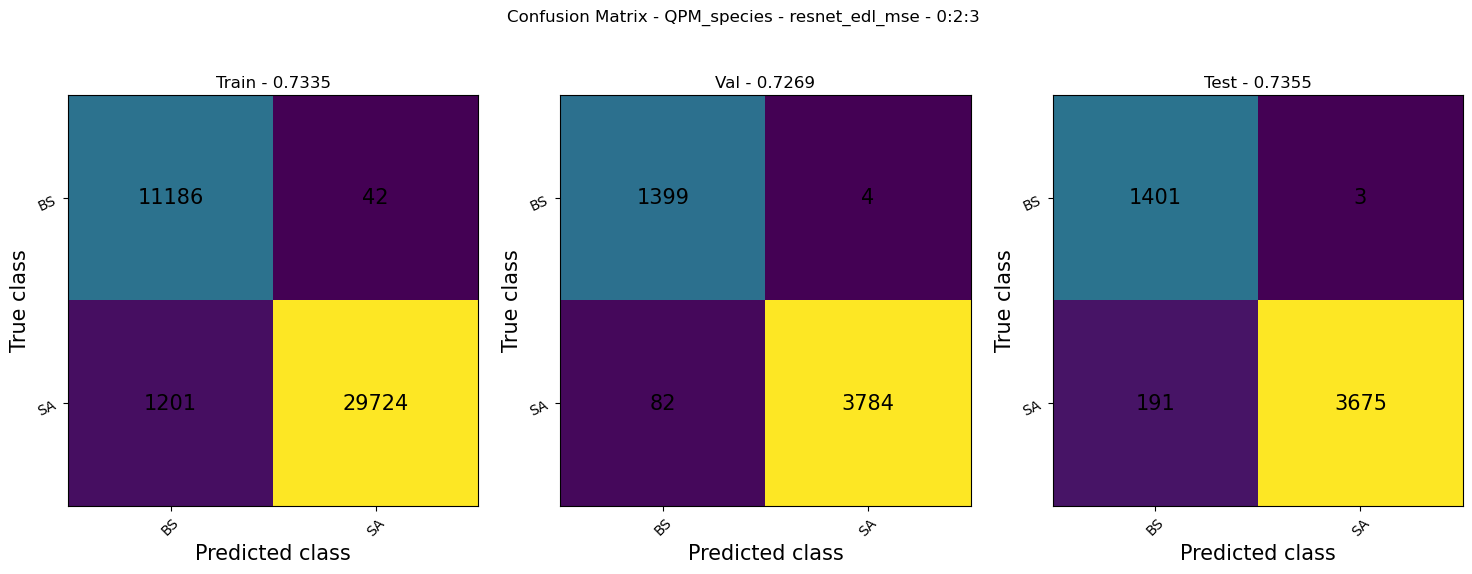

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


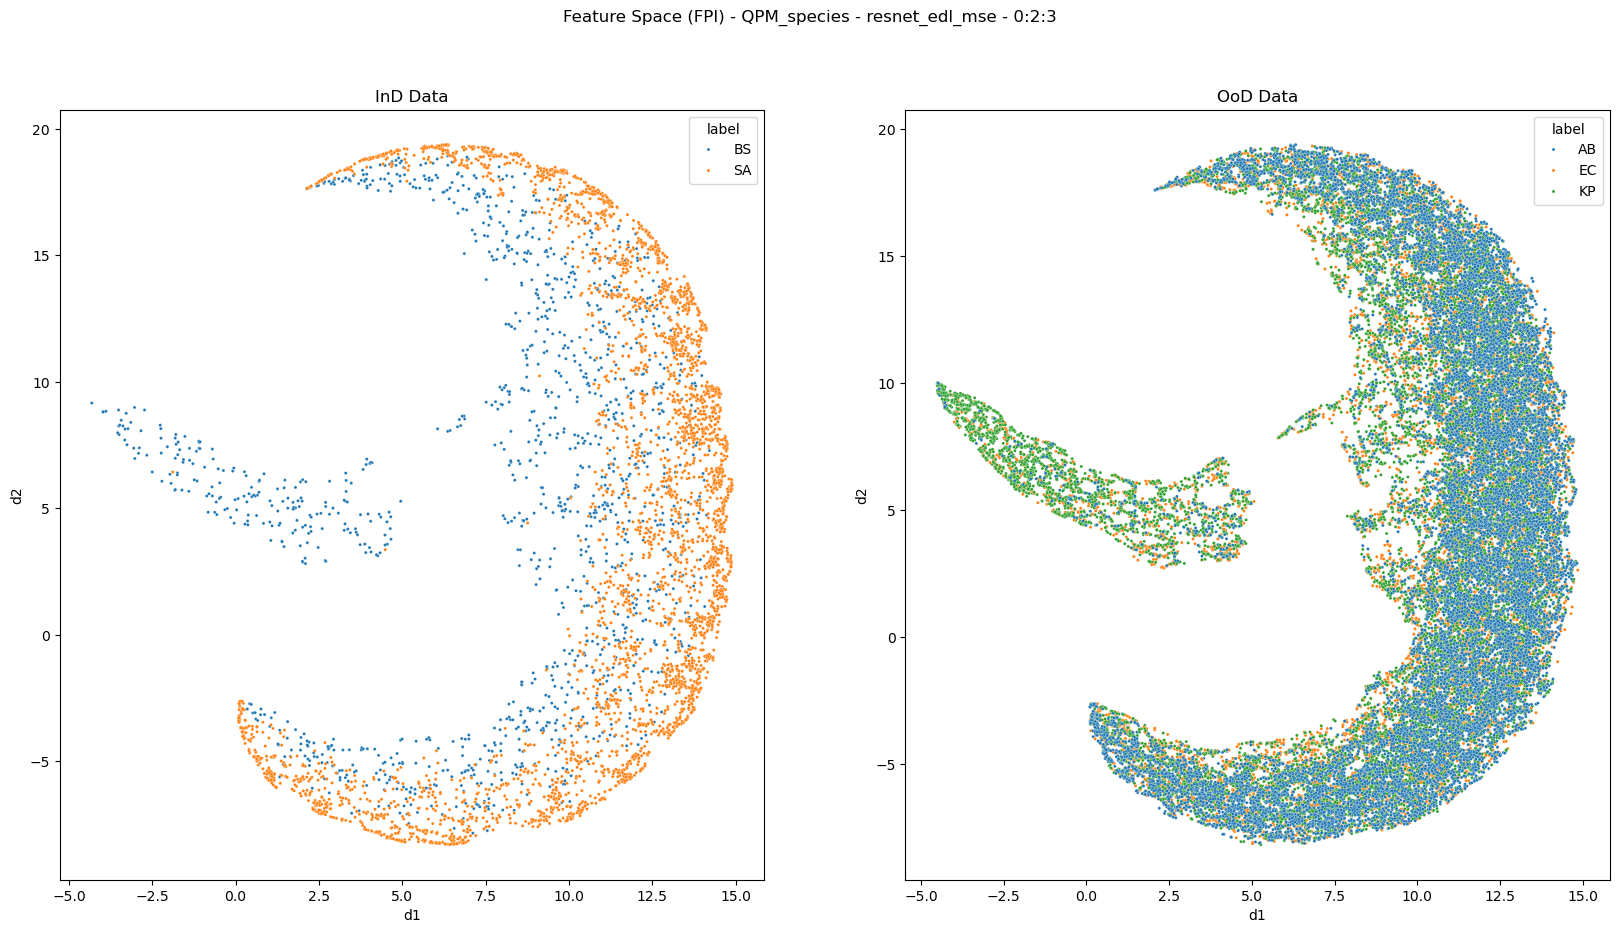

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

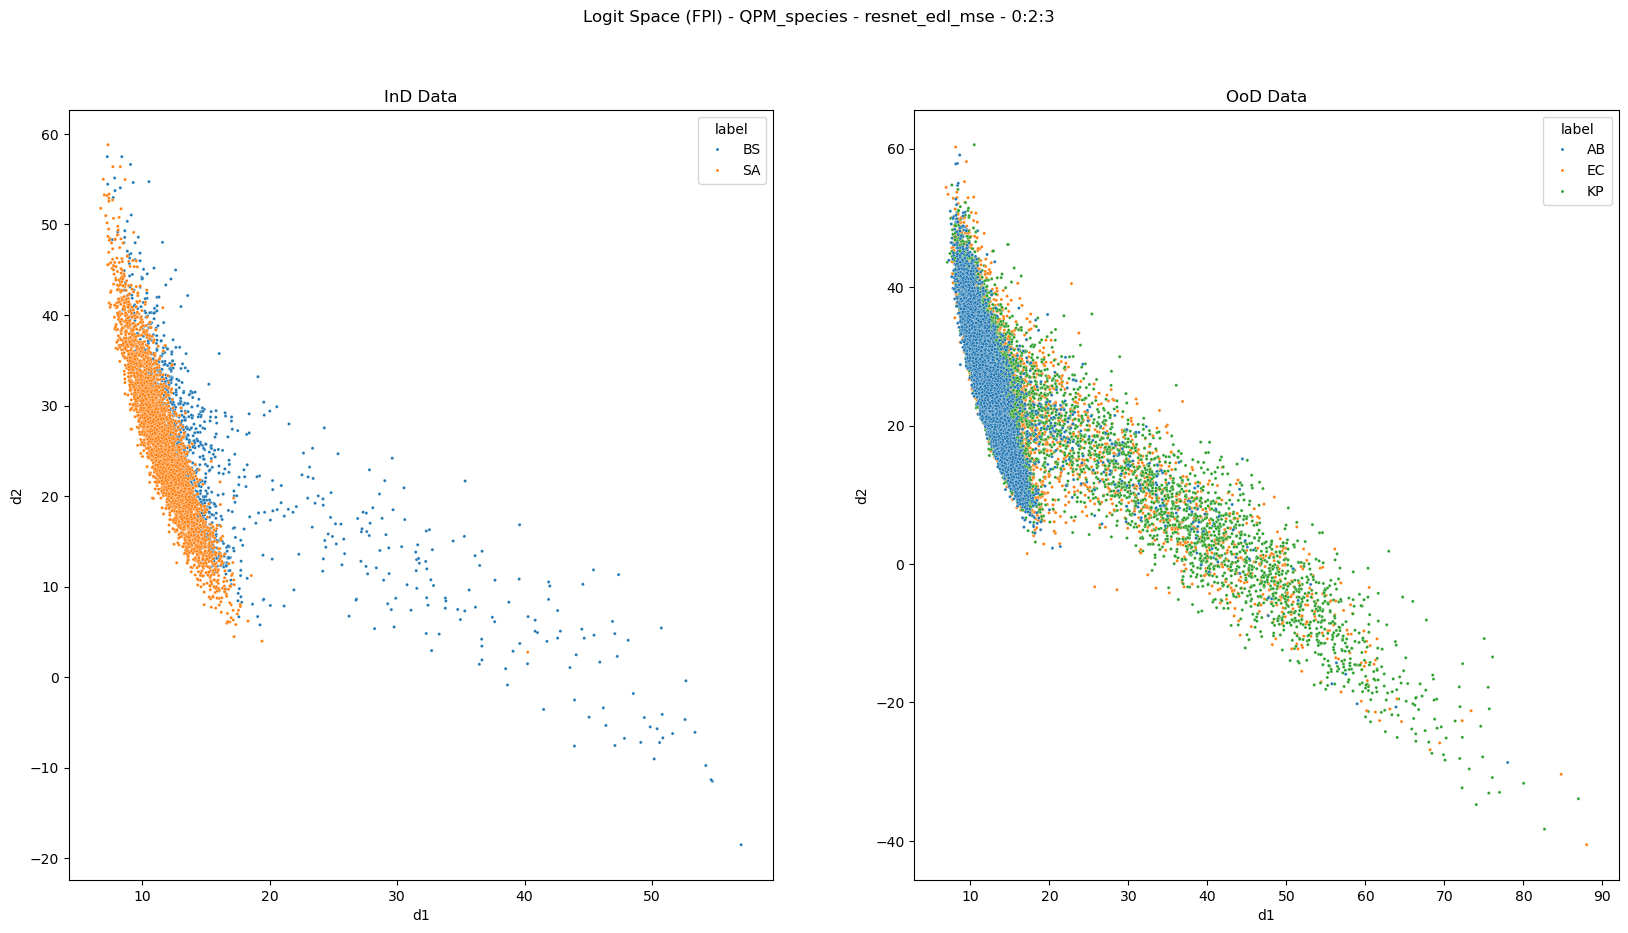

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

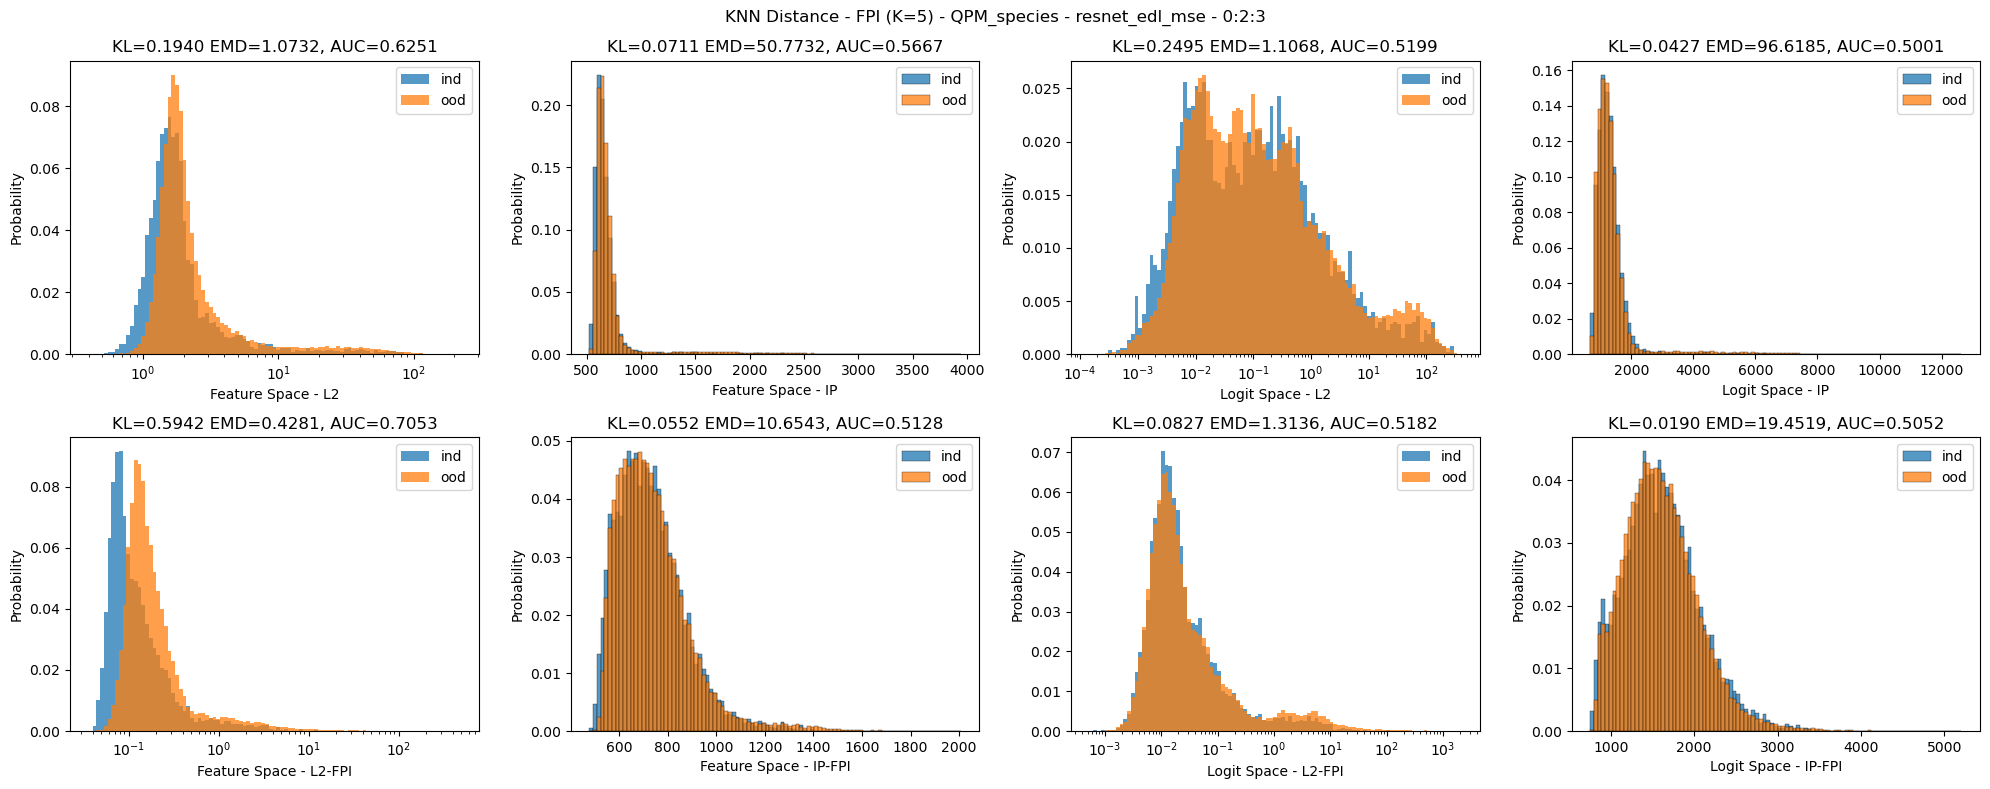

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

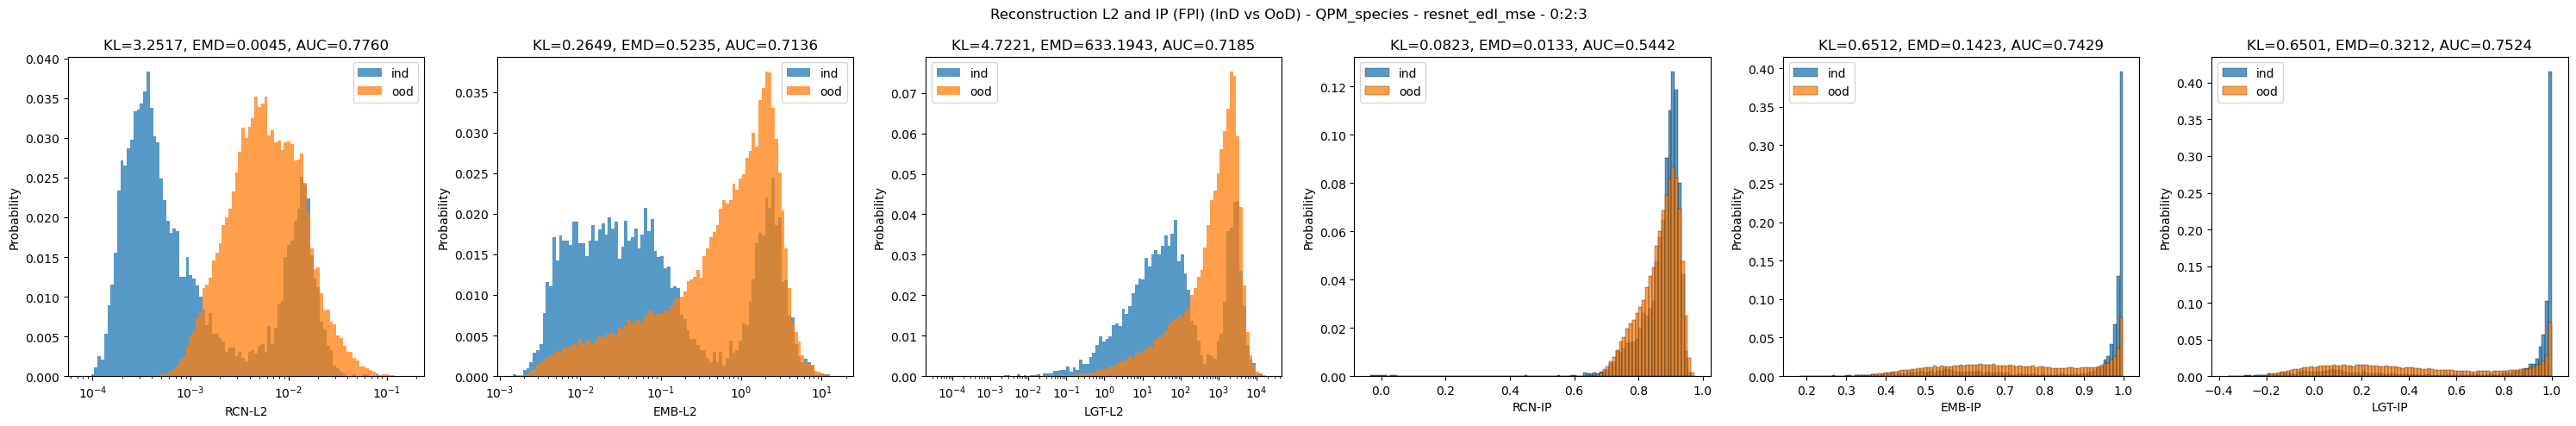

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

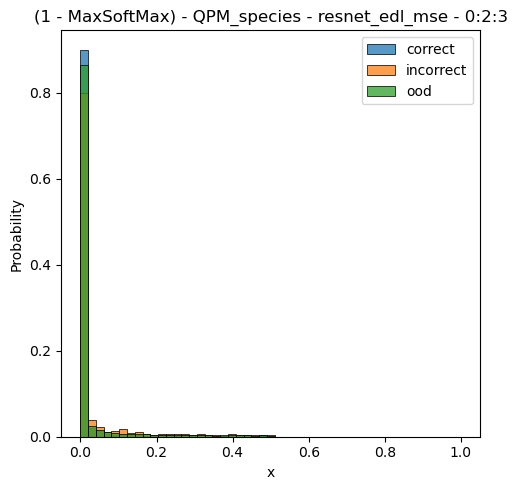

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

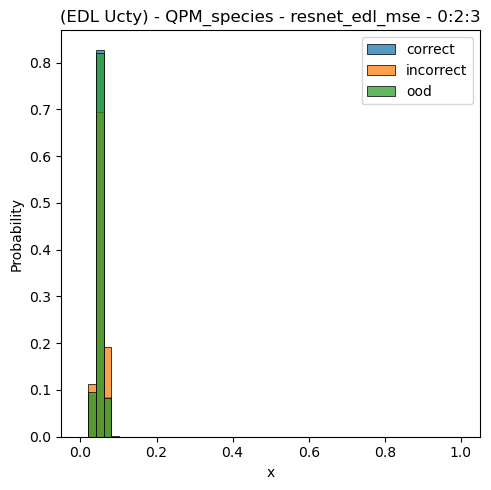

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()